# **Part A**
Count / Frequency based Naive Bayes Classifier

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Students must implement the following steps:
# 1. Complete the fit method in NaiveBayesClassifier (4 TODOs for log prior and log likelihood calculation).
# 2. Complete the predict method in NaiveBayesClassifier (2 TODOs for log probability accumulation and final argmax).
# 3. Complete the data loading calls in Section 2.
# 4. Initialize CountVectorizer with proper parameters in Section 3a.
# 5. Complete the feature transformation (fit_transform and transform) in Section 3a.
# 6. Initialize and fit the custom nb_model in Section 3b.
# 7. Use the fitted nb_model to generate predictions in Section 4.
# =======================================================

# This cell imports all the required libraries for the lab, such as
# pandas for data manipulation, numpy for numerical operations,
# sklearn for metrics, and matplotlib/seaborn for plotting.
#
# It also defines:
# 1. The `load_pubmed_rct_file` function to read the dataset.
# 2. The complete class structure for the custom `NaiveBayesClassifier`,
#    including the `fit` and `predict` methods that the student will complete.
# Data loading function (DO NOT CHANGE)
def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


# Implementing Multinomial Naive Bayes from scratch
class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    It is suitable for both Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]

            # // TODO: Calculate the log prior and store it in self.class_priors[c]
            # Calculate Class Prior P(C): log(P(C))
            # P(C) = (Number of samples in class c) / (Total number of samples)
            self.class_priors[c] = np.log(X_c.shape[0] / X_counts.shape[0])

            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            # Apply Laplace smoothing (additive smoothing, alpha=1.0 default):
            # P(w_i | C) = (count(w_i, C) + alpha) / (total_words_in_C + alpha * vocab_size)

            # // TODO: Calculate the numerator (with Laplace smoothing)
            numerator = feature_sum + self.alpha

            # // TODO: Calculate the denominator (with Laplace smoothing)
            denominator = total_mass + self.alpha * self.vocabulary_size

            # // TODO: Calculate the log likelihood (log(numerator / denominator))
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}

            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                non_zero_indices = x_i.indices
                non_zero_data = x_i.data

                # // TODO: Complete the log probability calculation for the likelihood term
                # Add log likelihoods contribution (Log-Sum Trick):
                # log_prob += sum(count(w_i) * log(P(w_i|C)))

                log_prob += np.sum(non_zero_data * log_likelihoods[non_zero_indices])
                scores[c] = log_prob

            # // TODO: Find the key (class label) with the maximum score
            predicted_class = max(scores, key=scores.get)

            y_pred.append(predicted_class)

        # // TODO: Return the final predictions array
        return np.array(y_pred)

In [ ]:
# Load and Prepare Data (DO NOT CHANGE)
# This cell loads the training, development (dev), and test datasets
# from their respective .txt files using the `load_pubmed_rct_file` function.
#
# It then separates the data into features (X) and labels (y) for each set
# and prints a summary of the data, including the number of samples in each
# set and the list of unique class names.
dir_path = './'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train/train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    # train_df = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # dev_df   = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # test_df  = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})


    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 2211861
Dev   samples: 28932
Test  samples: 29493
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [ ]:
# Feature Extraction and Custom Model Training
# This cell performs feature extraction and model training for Part A.
#
# 1. Feature Extraction: It initializes a `CountVectorizer` to convert the
#    raw text into word count vectors. It's configured to use n-grams of
#    1 and 2 words (`ngram_range=(1, 2)`) and to ignore words that appear
#    in fewer than 5 documents (`min_df=5`).
#
# 2. Transformation: It fits the vectorizer on the training data (`X_train`)
#    and transforms both the training and test data into count matrices
#    (`X_train_counts`, `X_test_counts`).
#
# 3. Model Training: It creates an instance of the custom `NaiveBayesClassifier`
#    (with `alpha=1.0` for Laplace smoothing) and trains it using the `fit`
#    method on the training counts and labels.
if X_train is not None and len(X_train) > 0:

    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        # // TODO: Set appropriate ngram_range
        ngram_range=(1, 2),
        # // TODO: Set appropriate min_df
        min_df=5
    )

    print("Fitting Count Vectorizer and transforming training data...")
    # // TODO: Fit the vectorizer on X_train and transform
    X_train_counts = count_vectorizer.fit_transform(X_train)
    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    # // TODO: Transform X_test using the fitted vectorizer
    X_test_counts = count_vectorizer.transform(X_test)


    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")

    # // TODO: Initialize the custom NaiveBayesClassifier
    nb_model = NaiveBayesClassifier(alpha=1.0)

    # // TODO: Fit the model using X_train_counts and y_train
    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")

Fitting Count Vectorizer and transforming training data...
Vocabulary size: 794979
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [ ]:
# Predict and evaluate on test set
# This cell evaluates the performance of the custom-built Naive Bayes model
# on the unseen test data.
#
# It calls the `predict` method of the `nb_model` (trained in the previous cell)
# to get predictions for `X_test_counts`.
#
# It then prints a detailed classification report, the overall accuracy,
# and the macro-averaged F1 score to assess the model's effectiveness.
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

# // TODO: Predict y_test_pred using X_test_counts
y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")


=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7731
              precision    recall  f1-score   support

  BACKGROUND       0.54      0.57      0.55      2663
 CONCLUSIONS       0.64      0.74      0.69      4426
     METHODS       0.85      0.85      0.85      9751
   OBJECTIVE       0.59      0.63      0.61      2377
     RESULTS       0.88      0.80      0.84     10276

    accuracy                           0.77     29493
   macro avg       0.70      0.72      0.71     29493
weighted avg       0.78      0.77      0.78     29493

Macro-averaged F1 score: 0.7077


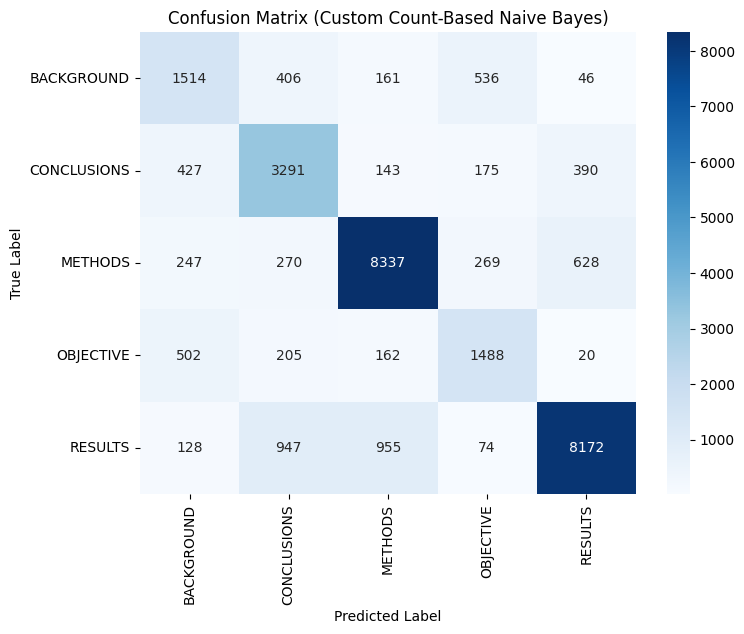

In [ ]:
# Confusion Matrix on test set
    # // TODO: Use the confusion_matrix, matplotlib, and seaborn libraries to generate
    # a visual confusion matrix (heatmap) for the predicted results.
# This cell generates a confusion matrix from the true test labels (`y_test`)
# and the model's predictions (`y_test_pred`).
#
# It then uses `matplotlib` and `seaborn` to create a heatmap visualization
# of the matrix, making it easier to analyze the model's performance and
# identify misclassifications between specific labels.
if y_test_pred is not None:
    cm = confusion_matrix(y_test, y_test_pred, labels=target_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Custom Count-Based Naive Bayes)')
    plt.show()

# **Part B**
TF-IDF score based Classifier

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Implement the following steps:
# 1. Define the initial `pipeline` combining TfidfVectorizer and MultinomialNB with default parameters.
# 2. Train the initial pipeline on the training data (X_train, y_train).
# 3. Predict and evaluate the performance of the initial model on the test data (X_test, y_test).
# 4. Define the `param_grid` for hyperparameter tuning.
# 5. Initialize `GridSearchCV` using the pipeline, parameter grid, and appropriate cross-validation settings.
# 6. Fit the Grid Search object using the development data (X_dev, y_dev).
# 7. Print the `best_params_` and `best_score_` found by the grid search.
# =======================================================

# This cell implements the entirety of Part B.
#
# 1. Imports: It imports the necessary `sklearn` modules, including
#    `TfidfVectorizer`, `MultinomialNB`, `Pipeline`, and `GridSearchCV`.
#
# 2. Baseline Model: It creates an `sklearn` `Pipeline` that first applies
#    `TfidfVectorizer` and then feeds the results to `MultinomialNB`.
#    This baseline pipeline is trained on `X_train` and evaluated on `X_test`.
#
# 3. Hyperparameter Tuning: It defines a `param_grid` to test different
#    hyperparameters for both the TF-IDF vectorizer (`ngram_range`) and
#    the Naive Bayes classifier (`alpha`).
#
# 4. Grid Search: It runs `GridSearchCV` on the development set (`X_dev`, `y_dev`)
#    to find the best combination of parameters, using 'f1_macro' as the
#    scoring metric.
#
# 5. Results: Finally, it prints the best parameters found and the
#    corresponding best score from the grid search.


# // TODO: Define a Pipeline named 'pipeline' using TfidfVectorizer and MultinomialNB.
# Use standard initial parameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# // TODO: Train the initial pipeline on the training set
print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")


# Predict and evaluate on test set
# // TODO: Predict y_test_pred and calculate metrics
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)
if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
else:
    print("Initial model evaluation skipped: Predictions not available.")


# Hyperparameter Tuning using GridSearchCV

# // TODO: Define the parameter grid 'param_grid' to tune both TF-IDF and NB parameters.
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.1, 0.5, 1.0]
}

# // TODO: Initialize GridSearchCV using the pipeline and param_grid.
# Ensure cv=3 and scoring='f1_macro' are used.
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)

print("\nStarting Hyperparameter Tuning on Development Set...")
# // TODO: Fit the GridSearchCV object using the development data.
grid.fit(X_dev, y_dev)
print("Grid search complete.")


if grid is not None and hasattr(grid, 'best_params_'):
    # // TODO: Print the best parameters and the corresponding best cross-validation score.
    print(f"Best parameters: {grid.best_params_}")
    print(f"Best cross-validation score (Macro F1): {grid.best_score_:.4f}")
else:
    print("Hyperparameter tuning skipped: Grid Search object not initialized or fitted.")

Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.7650
              precision    recall  f1-score   support

  BACKGROUND       0.67      0.39      0.49      2663
 CONCLUSIONS       0.65      0.70      0.67      4426
     METHODS       0.79      0.87      0.83      9751
   OBJECTIVE       0.73      0.41      0.53      2377
     RESULTS       0.81      0.87      0.84     10276

    accuracy                           0.76     29493
   macro avg       0.73      0.65      0.67     29493
weighted avg       0.76      0.76      0.75     29493

Macro-averaged F1 score: 0.6715

Starting Hyperparameter Tuning on Development Set...
Grid search complete.
Best parameters: {'nb__alpha': 0.1, 'tfidf__ngram_range': (1, 2)}
Best cross-validation score (Macro F1): 0.6456


# **Part C**
Bayes Optimal Classifier

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# =======================================================
# TODO: Implement the following steps:
# 1. Define the five diverse hypothesis pipelines (H1 to H5) using TfidfVectorizer
#    and the specified classifiers (NB, LR, RF, DT, KNN).
# 2. Train each of the five hypotheses on the sampled training data.
# 3. Create a list of estimators for the VotingClassifier.
# 4. Initialize and fit the VotingClassifier (Bayes Optimal Classifier approximation).
# 5. Make final predictions and evaluate the BOC performance on the test data.
# =======================================================

# Sampling for faster training of multiple models (DO NOT CHANGE)
#
# *** STUDENT ACTION REQUIRED ***
# This section dynamically calculates the sample size based on the student's SRN.
# When running this cell, a prompt will appear asking for the full SRN.
#
# This cell sets up the experiment for Part C.
#
# 1. Imports: It imports various classifiers from `sklearn` (like
#    `LogisticRegression`, `RandomForestClassifier`, `KNeighborsClassifier`, etc.)
#    to build a diverse set of models.
#
# 2. Sampling: It prompts the user for their SRN (Student Registration Number)
#    to dynamically calculate a sample size. This is done to create a smaller,
#    sampled subset of the training data (`X_train_sampled`, `y_train_sampled`)
#    to reduce the computation time for training multiple models.
#
# 3. Pipeline Definitions: It defines five different classification pipelines
#    (`h1` to `h5`). Each pipeline combines the same `TfidfVectorizer`
#    (with fixed parameters) with a different classifier:
#    - h1: Multinomial Naive Bayes
#    - h2: Logistic Regression
#    - h3: Random Forest
#    - h4: Decision Tree
#    - h5: K-Nearest Neighbors
BASE_SAMPLE_SIZE = 10000

FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")

try:
    if len(FULL_SRN) >= 3:
        print("My SRN is " + FULL_SRN)
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        raise ValueError("SRN too short.")
except (ValueError, IndexError):
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value

print(f"Using dynamic sample size: {SAMPLE_SIZE}")

# Assuming X_train and y_train were loaded in Part A
# Placeholder initialization in case data wasn't loaded in the environment
if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one", "sample text two", "sample text three"])
    y_train = pd.Series(["BACKGROUND", "METHODS", "RESULTS"])
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

# Create the sampled training subset
# Ensure SAMPLE_SIZE does not exceed the size of the actual training data
effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")

X_train_sampled = X_train[:SAMPLE_SIZE]
y_train_sampled = y_train[:SAMPLE_SIZE]
print(f"Using {len(X_train_sampled)} samples for training base models.")

# Base TF-IDF parameters (DO NOT CHANGE)
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1),
    'min_df': 5
}

# Define the five diverse hypotheses/pipelines

# Multinomial Naive Bayes
h1_nb = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', MultinomialNB(alpha=1.0, fit_prior=False))])

# Logistic Regression
h2_lr = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))])

# Random Forest Classifier
h3_rf = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1))])

# Decision Tree Classifier
h4_dt = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', DecisionTreeClassifier(max_depth=10, random_state=42))])

# K-Nearest Neighbors
h5_knn = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']

My SRN is PES2UG23CS195
Using dynamic sample size: 10195
Actual sampled training set size used: 10195
Using 10195 samples for training base models.


In [ ]:
# Implement and Evaluate the Bayes Optimal Classifier

# This cell creates and trains the ensemble model for Part C.
#
# 1. Estimators: It bundles the five pipelines defined in the previous
#    cell into a list of `estimators` for the voting classifier.
#
# 2. Voting Classifier: It initializes a `VotingClassifier` using this list,
#    setting `voting='hard'`. This means the ensemble's final prediction
#    will be the class that gets the "majority vote" from the five base models.
#
# 3. Training & Prediction: The `VotingClassifier` (named `boc_hard_voter`)
#    is then trained on the sampled training data. Finally, it generates
#    predictions on the full, unseen test set (`X_test`).

# List of (name, estimator) tuples for the VotingClassifier
estimators = list(zip(hypothesis_names, hypotheses))

# Hard Voting (Majority Rule) for BOC approximation
# // TODO: Initialize the VotingClassifier using 'estimators'
boc_hard_voter = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

print("\nFitting the VotingClassifier (BOC approximation)...")
# // TODO: Fit the VotingClassifier using the sampled training data
boc_hard_voter.fit(X_train_sampled, y_train_sampled)

# Make the final BOC prediction on the test set
# // TODO: Predict y_boc_pred using X_test
y_boc_pred = boc_hard_voter.predict(X_test)
print("Fitting complete.")


Fitting the VotingClassifier (BOC approximation)...
Fitting complete.


In [ ]:
# // TODO: Train all five hypotheses on X_train_sampled and y_train_sampled using a for loop
# This cell explicitly trains each of the five base classifiers
# (NaiveBayes, LogisticRegression, etc.) one by one.
#
# It iterates through the list of `estimators` and calls the `fit` method
# for each pipeline on the sampled training data.
#
# (Note: The `VotingClassifier` in the previous cell also performs this
# fitting internally when its `.fit()` method is called, but this
# cell runs the training for each model explicitly.)
print("Training all base models...")
for name, hypothesis in estimators:
     print(f"Training {name}...")
     hypothesis.fit(X_train_sampled, y_train_sampled)
     print(f"{name} trained.")
print("All base models trained.")

Training all base models...
Training NaiveBayes...
NaiveBayes trained.
Training LogisticRegression...


C:\Users\Nithin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Nithin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


LogisticRegression trained.
Training RandomForest...
RandomForest trained.
Training DecisionTree...
DecisionTree trained.
Training KNN...
KNN trained.
All base models trained.


In [ ]:
# Evaluate the Bayes Optimal Classifier (BOC)
# This cell evaluates the performance of the final ensemble model
# (the "Bayes Optimal Classifier" approximation) on the test set.
#
# It uses the predictions generated in Cell 11 (`y_boc_pred`) and compares
# them to the true labels (`y_test`) to calculate and print the
# overall accuracy, the macro F1 score, and a detailed classification report.
print("\n=== Final Evaluation: Bayes Optimal Classifier (Hard Voting) ===")

if 'y_boc_pred' in locals() and y_boc_pred is not None:
    # // TODO: Define Accuracy and Macro F1 Score
    boc_accuracy = accuracy_score(y_test, y_boc_pred)
    boc_f1 = f1_score(y_test, y_boc_pred, average='macro')

    print(f"BOC Accuracy: {boc_accuracy:.4f}")
    print(f"BOC Macro F1 Score: {boc_f1:.4f}")
    print(classification_report(y_test, y_boc_pred, target_names=target_names))
else:
    print("Prediction step failed or incomplete.")


=== Final Evaluation: Bayes Optimal Classifier (Hard Voting) ===
BOC Accuracy: 0.6725
BOC Macro F1 Score: 0.5446
              precision    recall  f1-score   support

  BACKGROUND       0.46      0.30      0.37      2663
 CONCLUSIONS       0.64      0.46      0.54      4426
     METHODS       0.60      0.93      0.73      9751
   OBJECTIVE       0.79      0.19      0.31      2377
     RESULTS       0.84      0.73      0.78     10276

    accuracy                           0.67     29493
   macro avg       0.67      0.52      0.54     29493
weighted avg       0.69      0.67      0.65     29493



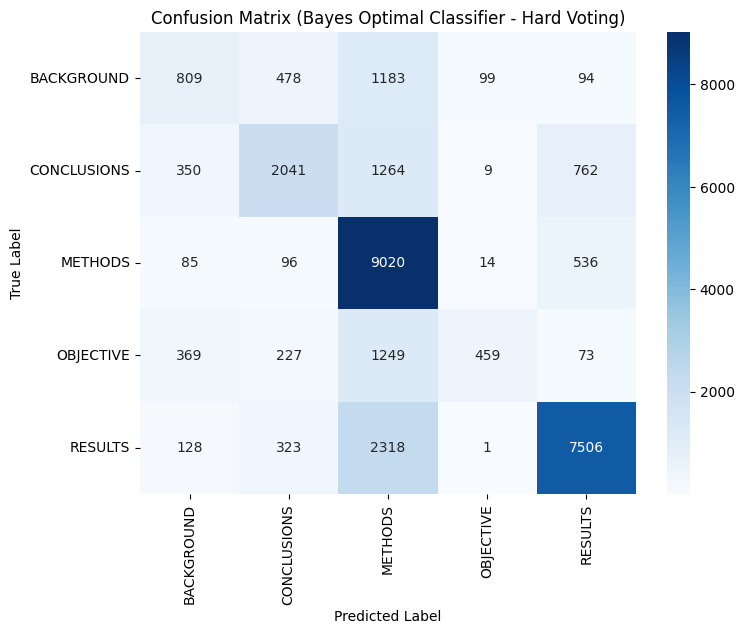

In [ ]:
# // TODO: Generate and visualize the Confusion Matrix (heatmap) for the BOC predictions.
# This cell evaluates the performance of the final ensemble model
# (the "Bayes Optimal Classifier" approximation) on the test set.
#
# It uses the predictions generated in Cell 11 (`y_boc_pred`) and compares
# them to the true labels (`y_test`) to calculate and print the
# overall accuracy, the macro F1 score, and a detailed classification report.
if 'y_boc_pred' in locals() and y_boc_pred is not None:
    cm_boc = confusion_matrix(y_test, y_boc_pred, labels=target_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_boc, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Bayes Optimal Classifier - Hard Voting)')
    plt.show()
else:
    print("Confusion Matrix skipped: Predictions not generated.")